# Imports

In [1]:
import pyxdf
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import librosa
import datetime
import matplotlib.pyplot as plt
import sounddevice as sd


# Load Data

In [2]:
sub_files = glob('../*/*.xdf')
sub_files

['../sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-5958030/sub-P5958030_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5899288/sub-P5899288_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5548165/sub-P5548165_ses-S001_task-CUNY_run-001_MOBI.xdf']

In [3]:
xdf_path = sub_files[3]
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]
      
streams_collected

['WebcamStream',
 'Tobii',
 'OpenSignals',
 'EGI NetAmp 0',
 'Stimuli_Markers',
 'Microphone']

# Stimulus

In [4]:
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['time'] = (stim_dat['time_stamps'] - stim_dat['time_stamps'][0])/1000
stim_df

,trigger,event,lsl_time_stamp,time
0,2.000000e+02,Onset_Experiment,1.073920e+06,0.000000e+00
1,1.735058e+09,psychopy_time_stamp,1.073920e+06,9.799609e-09
2,1.000000e+01,Onset_RestingState,1.073940e+06,1.976684e-02
3,1.735058e+09,psychopy_time_stamp,1.073940e+06,1.976685e-02
4,1.100000e+01,Offset_RestingState,1.074240e+06,3.197662e-01
...,...,...,...,...
256,1.735060e+09,psychopy_time_stamp,1.076101e+06,2.180627e+00
257,2.010000e+02,Offset_Experiment,1.076106e+06,2.185632e+00
258,1.735060e+09,psychopy_time_stamp,1.076106e+06,2.185632e+00
259,4.000000e+00,Bx_input,1.076106e+06,2.185633e+00


# Microphone Data 

In [5]:
mic_data = data[streams_collected.index('Microphone')]
mic_df = pd.DataFrame(mic_data['time_series'], columns=['int_array'])
mic_df['bytestring'] = mic_df['int_array'].apply(lambda x: np.array(x).tobytes())
# mic_df['time_stamps'] = (mic_data['time_stamps'] - mic_data['time_stamps'][0])/441000

mic_df['lsl_time_stamp'] = mic_data['time_stamps']
# mic_df['time'] = (mic_df.lsl_time_stamp - mic_df.lsl_time_stamp[0])
mic_df['time_delta'] = mic_df['lsl_time_stamp'].diff()

mic_df.tail()

,int_array,bytestring,lsl_time_stamp,time_delta
84275096,-12,b'\xf4\xff\xff\xff\xff\xff\xff\xff',1.076166e+06,0.000023
84275097,-9,b'\xf7\xff\xff\xff\xff\xff\xff\xff',1.076166e+06,0.000023
84275098,8,b'\x08\x00\x00\x00\x00\x00\x00\x00',1.076166e+06,0.000023
84275099,-3,b'\xfd\xff\xff\xff\xff\xff\xff\xff',1.076166e+06,0.000023
84275100,33,b'!\x00\x00\x00\x00\x00\x00\x00',1.076166e+06,0.000023


In [11]:
onset_story = mic_df.loc[(mic_df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_CampFriend', 'lsl_time_stamp'].values[0])]

## Compare wav and LSL lengths

In [54]:
# get wav file
wav_files = glob('../*/*.wav')
wav_files

wav_path = wav_files[0]
wav_path

'../sub-P5318014/sub-P5318014_task-CUNY_run-001_mic.wav'

In [55]:
# calculate wav and lsl durations
wav_dur = round(librosa.get_duration(path=wav_path), 2)
lsl_dur = round(mic_df['lsl_time_stamp'].iloc[-1]- mic_df['lsl_time_stamp'].iloc[0], 2)

# convert to hh:mm:ss
wav_dt = datetime.timedelta(seconds=wav_dur)
wav_dur_dt = str(datetime.timedelta(seconds=round(wav_dt.total_seconds())))
lsl_dt = datetime.timedelta(seconds=lsl_dur)
lsl_dur_dt = str(datetime.timedelta(seconds=round(lsl_dt.total_seconds())))


# make df of durations
variables = {name: [globals()[name], globals()[name+'_dt']]  for name in ['wav_dur', 'lsl_dur']}
durations_df = pd.DataFrame.from_dict(variables, orient = 'index', columns = ['seconds', 'mm:ss'])
print(durations_df.to_string() + '\n')

# print if they are close or not (margin on 5 seconds rn)
if abs(wav_dur - lsl_dur) > 5:
    print(f'Warning: The duration of the wav file ({wav_dur}) and the duration of the lsl time stamps ({lsl_dur}) differ by more than 5 seconds. \n')
    if wav_dur > lsl_dur:
        print('The wav file is longer than the lsl time stamps by {} seconds'.format(wav_dur - lsl_dur))
    if lsl_dur > wav_dur:
        print('The lsl time stamps are longer than the wav file by {} seconds'.format(lsl_dur - wav_dur))
else: 
    print('The wav file and the lsl time stamps are the same length!')

         seconds    mm:ss
wav_dur  1989.40  0:33:09
lsl_dur  1989.48  0:33:09

The wav file and the lsl time stamps are the same length!


In [ ]:
abs(wav_dur - lsl_dur)

## Range

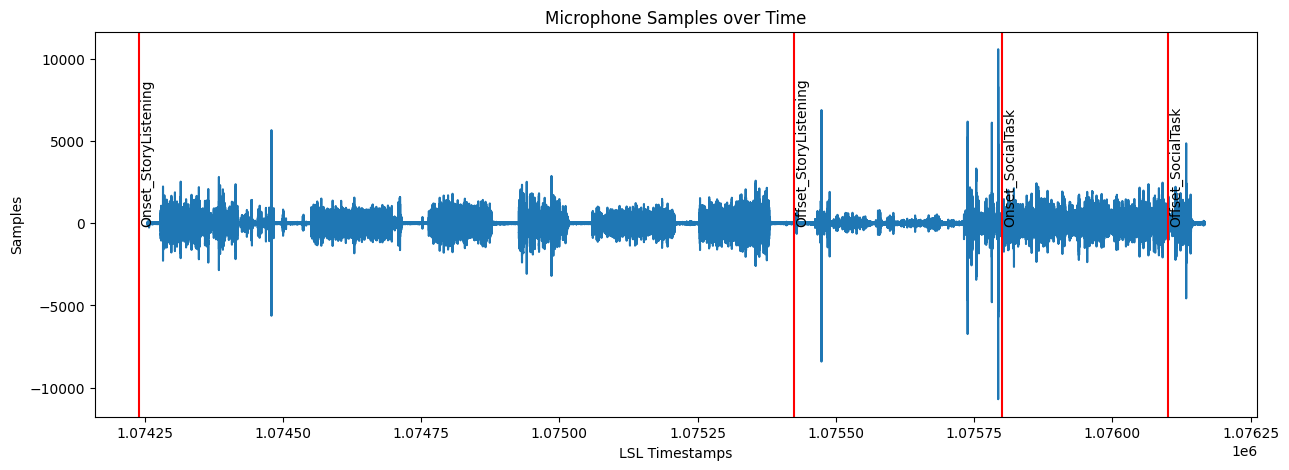

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(mic_df.lsl_time_stamp, mic_df.int_array)
for event in stim_df.loc[stim_df.event.str.contains('StoryListening|SocialTask')].iterrows():
    plt.axvline(event[1]['lsl_time_stamp'], color='r')
    plt.text(event[1]['lsl_time_stamp']+2, 0, event[1]['event'], rotation=90)

plt.xlabel('LSL Timestamps')
plt.ylabel('Samples')
plt.title('Microphone Samples over Time')
plt.show()

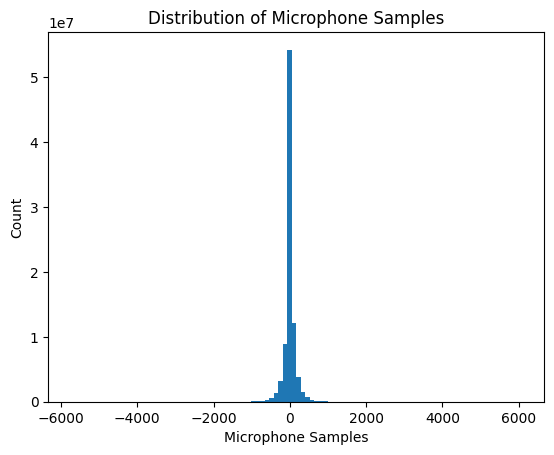

In [57]:
plt.hist(mic_df['int_array'], bins=100)
plt.xlabel('Microphone Samples')
plt.ylabel('Count')
plt.title('Distribution of Microphone Samples')
plt.show()

# looking to make sure it's relatively centered around 0, no outlier peaks, no values above 32k or below -32k

### Stats that might not be included


In [58]:
# 25% and 75% quantiles
quan25 = np.quantile(mic_df['int_array'], 0.25)
quan75 = np.quantile(mic_df['int_array'], 0.75)

if quan75 - quan25 > 100:
    print('range is really large??')
print('first quartile: {} \nsecond quartile: {}'.format(quan25, quan75))

# standard dev
print("standard deviation: {:.4f}".format(mic_df['int_array'].std()))

# range, should be between -32768 and 32767
print("min: ", min(mic_df.int_array), "\nmax: ", max(mic_df.int_array))

first quartile: -37.0 
second quartile: 37.0
standard deviation: 157.3225
min:  -5742 
max:  6073


In [59]:
# no of NA's
print("number of NaN's: ", mic_df['int_array'].isna().sum())

number of NaN's:  0


## Sampling Rate

In [60]:
nom_srate = float(mic_data['info']['nominal_srate'][0])
eff_srate = mic_data['info']['effective_srate']
srate_diff = 44100.00 - eff_srate

if nom_srate != 44100.0:
    print(f"Alert! Nominal sampling rate is not 44.1 kHz! It is {nom_srate}")
if abs(srate_diff) > 5: # 5?
    print(f'Alert! Effective sampling rate is not 44.1 kHz! It is {eff_srate} Hz, {srate_diff} Hz away from 44.1kHz')

print(f'nominal sampling rate: {nom_srate}\neffective sampling rate: {eff_srate:.4f}')


nominal sampling rate: 44100.0
effective sampling rate: 44098.1454
